In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats
!pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (201.3 MB)


# Data Pre-Processing
In this section, we process the input data sets (categories, ERA5 and EVI), filter for relevant details and prepare the input data.

## Load categories

In [3]:
categories = pd.read_csv('data/categories.csv')
categories['values'].unique()

array(['AX41008_AX_SportFreizeitUndErholungsflaeche__Park',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Schwimmbad, Freibad',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Grünanlage',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Freizeitanlage',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Sportanlage',
       'AX43007_AX_UnlandVegetationsloseFlaeche__Naturnahe Fläche',
       'AX43003_AX_Gehoelz__',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Kleingarten',
       'AX41009_AX_Friedhof__',
       'AX43007_AX_UnlandVegetationsloseFlaeche__Vegetationslose Fläche',
       'AX43002_AX_Wald_Laubholz_',
       'AX54001_AX_Vegetationsmerkmal__Gehölz__',
       'AX54001_AX_Vegetationsmerkmal__Baumbestand, Laubholz__',
       'AX54001_AX_Vegetationsmerkmal__Gebüsch__',
       'AX51006_AX_BauwerkOderAnlageFuerSportFreizeitUndErholung_Spielfeld___',
       'AX54001_AX_Vegetationsmerkmal__Baumbestand, Laub- und Nadelholz__',
       'AX51006_AX_BauwerkOderAn

## Read urban climate data

In [4]:
era_5_berlin = pd.read_csv('data/era5_berlin_wide.csv')

In [5]:
era_5_berlin

,cell,x,y,time,SFC=Ground or water surface; Precipitation type [0=Reserved; 1=Rain; 2=Thunderstorm; 3=Freezing rain; 4=Mixed/ice; 5=Snow; 6=Wet snow; 7=Mixture of rain and snow; 8=Ice pellets; 9=Graupel; 10=Hail; 11=Drizzle; 12=Freezing drizzle; 13-191=Reserved; 192-254=Reserved for local use; 255=Missing],SFC (Ground or water surface); 2 metre temperature [C],SFC (Ground or water surface); 10m. Windspeed (irresp of dir.) [m/s],SFC (Ground or water surface); Total cloud cover (0 - 1) [-],SFC (Ground or water surface); Snow depth (water equivalent) [m],SFC (Ground or water surface); Total column ozone Dobson [kg/m^2],...,7-28[cm] DBLY (layer between 2 depths below land surface); Volumetric soil water layer 2 [m^3/m^3],28-100[cm] DBLY (layer between 2 depths below land surface); Volumetric soil water layer 3 [m^3/m^3],100-255[cm] DBLY (layer between 2 depths below land surface); Volumetric soil water layer 4 [m^3/m^3],SFC (Ground or water surface); Total precipitation [m],SFC (Ground or water surface); Instantaneous 10 metre wind gust [m/s],SFC (Ground or water surface); Evaporation (of water) [m],SFC (Ground or water surface); undefined [-],SFC (Ground or water surface); Runoff [m],SFC (Ground or water surface); Snow fall (of water equivalent) [m],SFC (Ground or water surface); Snowmelt [m of water equivalent]
0,1,13.00,52.75,2000-01-01,2.192261,274.697388,4.429860,0.777746,0.000835,0.006558,...,0.368937,0.348786,0.319275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,13.25,52.75,2000-01-01,2.192261,274.543091,4.489675,0.774130,0.000897,0.006570,...,0.367412,0.345383,0.317291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,13.50,52.75,2000-01-01,2.362915,274.339966,4.540212,0.770041,0.000871,0.006580,...,0.363780,0.334534,0.310974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,13.75,52.75,2000-01-01,2.383057,274.275513,4.591725,0.766852,0.000806,0.006592,...,0.362407,0.334183,0.310974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,13.00,52.50,2000-01-01,2.032227,274.656372,4.389577,0.768515,0.001181,0.006570,...,0.365809,0.337784,0.312057,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,8,13.75,52.50,2025-01-01,1.266113,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3608,9,13.00,52.25,2025-01-01,1.256714,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3609,10,13.25,52.25,2025-01-01,1.205688,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3610,11,13.50,52.25,2025-01-01,1.205688,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Process ERA5 data
- drop null values, filter for Berlin rasters, aggregate data, drop categorical columns, create date_key as identifier

In [6]:
# code generation supported by ChatGPT
era_5_berlin = era_5_berlin.dropna()

filtered_era5 = era_5_berlin[era_5_berlin['cell'].isin([6, 7])]

era_5_berlin = filtered_era5.groupby('time').mean(numeric_only=True)
era_5_berlin.drop(columns=["SFC=Ground or water surface; Precipitation type [0=Reserved; 1=Rain; 2=Thunderstorm; 3=Freezing rain; 4=Mixed/ice; 5=Snow; 6=Wet snow; 7=Mixture of rain and snow; 8=Ice pellets; 9=Graupel; 10=Hail; 11=Drizzle; 12=Freezing drizzle; 13-191=Reserved; 192-254=Reserved for local use; 255=Missing]"], inplace=True)
#era_5_berlin.drop(columns=["SFC (Ground or water surface); undefined [-]"], inplace=True)
era_5_berlin.index = pd.to_datetime(era_5_berlin.index)
era_5_berlin['date_key'] = era_5_berlin.index.strftime('%Y_%m')
print(era_5_berlin.head())

            cell       x     y  \
time                             
2000-02-01   6.5  13.375  52.5   
2000-03-01   6.5  13.375  52.5   
2000-04-01   6.5  13.375  52.5   
2000-05-01   6.5  13.375  52.5   
2000-06-01   6.5  13.375  52.5   

            SFC (Ground or water surface); 2 metre temperature [C]  \
time                                                                 
2000-02-01                                         277.434357        
2000-03-01                                         278.502380        
2000-04-01                                         284.619781        
2000-05-01                                         288.967682        
2000-06-01                                         291.274292        

            SFC (Ground or water surface); 10m. Windspeed (irresp of dir.) [m/s]  \
time                                                                               
2000-02-01                                           4.502243                      
2000-03-01        

## Rename variable names to improve readability

In [8]:
era_5_berlin.columns
era_5_berlin.rename(columns={'SFC (Ground or water surface); 2 metre temperature [C]': '2 metre temperature'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); 10m. Windspeed (irresp of dir.) [m/s]': '10m. Windspeed'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Total cloud cover (0 - 1) [-]': 'Total cloud cover'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Snow depth (water equivalent) [m]': 'Snow depth'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Total column ozone Dobson [kg/m^2]': 'Ozone Dobson'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Total column water [kg/m^2]': 'Water [kg/m^2]'}, inplace=True)
era_5_berlin.rename(columns={'0-7[cm] DBLY (layer between 2 depths below land surface); Surf.temp/soil temp lev 1 (from 930804) [C]': 'Surf.temp lev 1'}, inplace=True)
era_5_berlin.rename(columns={'7-28[cm] DBLY (layer between 2 depths below land surface); Deep soil tmp/soil temp lev2(from 930804) [C]': 'Deep soil temp lev2'}, inplace=True)
era_5_berlin.rename(columns={'28-100[cm] DBLY (layer between 2 depths below land surface); Clim deep soil tmp/soil tmp lev3(930804) [C]': 'Deep soil tmp lev3'}, inplace=True)
era_5_berlin.rename(columns={'100-255[cm] DBLY (layer between 2 depths below land surface); Soil temperature level 4 [C]': 'Deep soil temperature level 4'}, inplace=True)

era_5_berlin.rename(columns={'0-7[cm] DBLY (layer between 2 depths below land surface); Volumetric soil water layer 1 [m^3/m^3]': 'Volumetric soil water layer 1'}, inplace=True)
era_5_berlin.rename(columns={'7-28[cm] DBLY (layer between 2 depths below land surface); Volumetric soil water layer 2 [m^3/m^3]': 'Volumetric soil water layer 2'}, inplace=True)
era_5_berlin.rename(columns={'28-100[cm] DBLY (layer between 2 depths below land surface); Volumetric soil water layer 3 [m^3/m^3]': 'Volumetric soil water layer 3'}, inplace=True)
era_5_berlin.rename(columns={'100-255[cm] DBLY (layer between 2 depths below land surface); Volumetric soil water layer 4 [m^3/m^3]': 'Volumetric soil water layer 4'}, inplace=True)

era_5_berlin.rename(columns={'SFC (Ground or water surface); Total precipitation [m]': 'Total precipitation'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); 2 metre temperature [C]': '2 metre temperature'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Instantaneous 10 metre wind gust [m/s]': 'Instantaneous 10 metre wind gust'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Evaporation (of water) [m]': 'Evaporation (of water)'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Runoff [m]': 'Runoff'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Snow fall (of water equivalent) [m]': 'Snow fall (of water equivalent)'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); Snowmelt [m of water equivalent]': 'Snowmelt'}, inplace=True)
era_5_berlin.rename(columns={'SFC (Ground or water surface); undefined [-]': 'Potential Evaporation'}, inplace=True)


era_5_berlin

,cell,x,y,2 metre temperature,10m. Windspeed,Total cloud cover,Snow depth,Ozone Dobson,Water [kg/m^2],Surf.temp lev 1,...,Volumetric soil water layer 3,Volumetric soil water layer 4,Total precipitation,Instantaneous 10 metre wind gust,Evaporation (of water),Potential Evaporation,Runoff,Snow fall (of water equivalent),Snowmelt,date_key
time,,,,,,,,,,,,,,,,,,,,,
2000-02-01,6.5,13.375,52.5,277.434357,4.502243,0.766450,6.437302e-05,0.007277,10.511624,276.782532,...,0.352684,0.308899,0.002046,8.544087,-0.000829,-0.000679,0.000082,0.000187,0.000021,2000_02
2000-03-01,6.5,13.375,52.5,278.502380,4.479791,0.835056,9.775162e-05,0.007368,12.009197,278.283722,...,0.374505,0.318871,0.003109,8.772180,-0.001207,-0.001059,0.000152,0.000307,0.000047,2000_03
2000-04-01,6.5,13.375,52.5,284.619781,3.271225,0.605054,0.000000e+00,0.007514,14.582932,283.899750,...,0.367944,0.331314,0.000972,6.487828,-0.002300,-0.002904,0.000149,0.000000,0.000000,2000_04
2000-05-01,6.5,13.375,52.5,288.967682,2.994980,0.442899,0.000000e+00,0.007363,16.850113,289.135498,...,0.287656,0.330589,0.001265,6.164965,-0.002838,-0.004596,0.000135,0.000000,0.000000,2000_05
2000-06-01,6.5,13.375,52.5,291.274292,3.657306,0.548546,0.000000e+00,0.006966,21.487869,291.658356,...,0.218221,0.323189,0.001400,7.530949,-0.002422,-0.005156,0.000103,0.000000,0.000000,2000_06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,6.5,13.375,52.5,294.340942,2.836612,0.554848,0.000000e+00,0.006790,28.386993,294.703857,...,0.168537,0.314781,0.001575,5.936646,-0.002155,-0.005022,0.000092,0.000000,0.000000,2024_08
2024-09-01,6.5,13.375,52.5,290.253510,3.999990,0.521767,0.000000e+00,0.006561,22.388275,290.373535,...,0.171809,0.306198,0.001743,7.764528,-0.001652,-0.003330,0.000067,0.000000,0.000000,2024_09
2024-10-01,6.5,13.375,52.5,284.325867,3.433255,0.682152,0.000000e+00,0.006235,20.476425,284.208771,...,0.211298,0.301819,0.001546,6.624738,-0.000928,-0.001055,0.000062,0.000000,0.000000,2024_10


## Load EVI Data

In [9]:
evi_aoi = pd.read_csv('data/EVI_AOI.csv')

In [10]:
evi_aoi

,cell,x,y,layer,values
0,324,390555,5823255,EVI_2000_01,0.165208
1,327,390645,5823255,EVI_2000_01,0.104556
2,1098,390465,5823225,EVI_2000_01,0.002613
3,1099,390495,5823225,EVI_2000_01,0.010328
4,1100,390525,5823225,EVI_2000_01,0.015046
...,...,...,...,...,...
2215950,238905,391815,5814045,EVI_2024_11,2.399851
2215951,238906,391845,5814045,EVI_2024_11,2.568649
2215952,239675,391605,5814015,EVI_2024_11,2.161526
2215953,239676,391635,5814015,EVI_2024_11,2.200696


Drop null values, detect and delete outliers

In [11]:
evi_aoi = evi_aoi.dropna(subset=['values'])

In [12]:
evi_min = evi_aoi.min()
evi_max = evi_aoi.max()
print("Min:", evi_min)
print("Max:", evi_max)

Min: cell              324
x              380865
y             5813055
layer     EVI_2000_01
values       -27840.0
dtype: object
Max: cell           264749
x              404145
y             5823255
layer     EVI_2024_11
values        27565.0
dtype: object


Remove outliers

In [13]:
lower_bound = evi_aoi['values'].quantile(0.05)
upper_bound = evi_aoi['values'].quantile(0.95)

evi_aoi = evi_aoi[(evi_aoi['values'] >= lower_bound) & (evi_aoi['values'] <= upper_bound)]

print(f"Lower Bound (5th Percentile): {lower_bound}")
print(f"Upper Bound (95th Percentile): {upper_bound}")

Lower Bound (5th Percentile): -4.456757593154907
Upper Bound (95th Percentile): 7.273000335693331


# Merge Datasets and prepare for Training

## Merge categories and EVI dataframe, filter for desired EVI dataset

In [14]:
def choose_cat_and_merge(df_evi, df_cat, cat):
    df_cat = df_cat[df_cat['values'] == cat]
    df_evi = pd.merge(df_evi, df_cat, on='cell', how='inner')
    return df_evi

## Merge ERA and EVI data

In [15]:
def merge_with_era5(df_era5, df_evi): 
    df_evi['date_key'] = df_evi['layer_x'].str.extract(r'(\d{4}_\d{2})')
    df_evi['year'] = df_evi['layer_x'].str.extract(r'EVI_(\d{4})').astype(int)
    df_evi = df_evi[df_evi['year'] <= 2021]
    evi_aoi_grouped = df_evi.groupby('date_key', as_index=False)['values_x'].mean()
    df = pd.merge(df_era5, evi_aoi_grouped, on='date_key', how='inner')
    return df


In [16]:
# Code debugged by ChatGPT
def select_columns(df1, correlation_threshold=0.9):
    corr_matrix = df1.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    df_cleaned = df1.drop(columns=to_drop)    
    print(f"Removed columns due to high collinearity: {to_drop}")
    return df_cleaned



In [17]:
# Code debugged by ChatGPT
def train_xgb(df):
    df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True)
    X = df.iloc[:, :-1]  # Select all columns except the last one (features)
    y = df.iloc[:, -1]   # Select only the last column (target)
    split_index = int(0.9 * len(df))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 1.0]
    }
    
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    best_model = XGBRegressor(objective='reg:squarederror', **best_params, random_state=42)
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    plt.figure(figsize=(10, 6))
    xgb.plot_importance(best_model, importance_type='weight', title='Feature Importance', height=0.8)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label="Actual", color='blue')
    plt.plot(y_test.index, y_pred, label="Predicted", color='red', linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("Target Value")
    plt.title("Actual vs. Predicted Values")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(X.corr(), annot=True, cmap="coolwarm", center=0)
    plt.title("Feature Correlation Heatmap")
    plt.show()

    return best_model


In [18]:
#columns that appear in the areas of interest
df_evi = pd.merge(evi_aoi, categories, on='cell', how='inner')
df_evi['values_y'].unique()

array(['AX54001_AX_Vegetationsmerkmal__Gehölz__',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Park',
       'AX54001_AX_Vegetationsmerkmal__Baumbestand, Laubholz__',
       'Grünanlage',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Schwimmbad, Freibad',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Freizeitanlage',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Sportanlage',
       'AX43007_AX_UnlandVegetationsloseFlaeche__Naturnahe Fläche',
       'Spielplatz', 'AX43003_AX_Gehoelz__',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Kleingarten',
       'AX41009_AX_Friedhof__',
       'AX54001_AX_Vegetationsmerkmal__Baumbestand, Laub- und Nadelholz__',
       'AX51006_AX_BauwerkOderAnlageFuerSportFreizeitUndErholung_Spielfeld___',
       'AX41008_AX_SportFreizeitUndErholungsflaeche__Grünanlage',
       'AX43007_AX_UnlandVegetationsloseFlaeche__Vegetationslose Fläche',
       'AX51006_AX_BauwerkOderAnlageFuerSportFreizeitUndErholung_Wildgehege___',
   

In [19]:
# Model Training

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error (MSE): 1.1173
Root Mean Squared Error (RMSE): 1.0570
Mean Absolute Error (MAE): 0.8903
R² Score: 0.0352


<Figure size 1000x600 with 0 Axes>

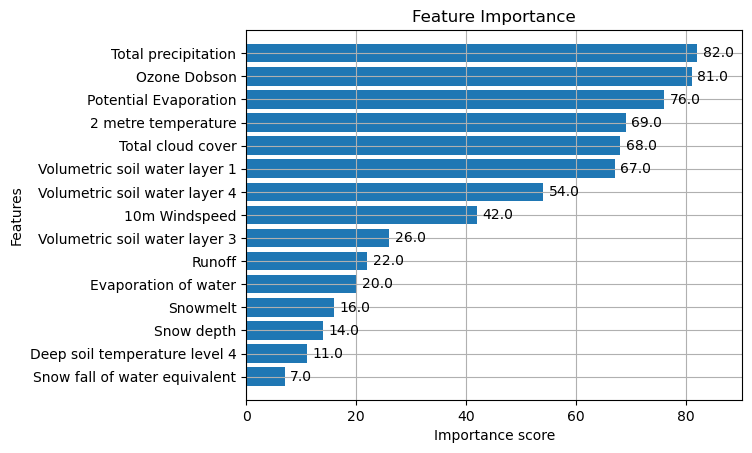

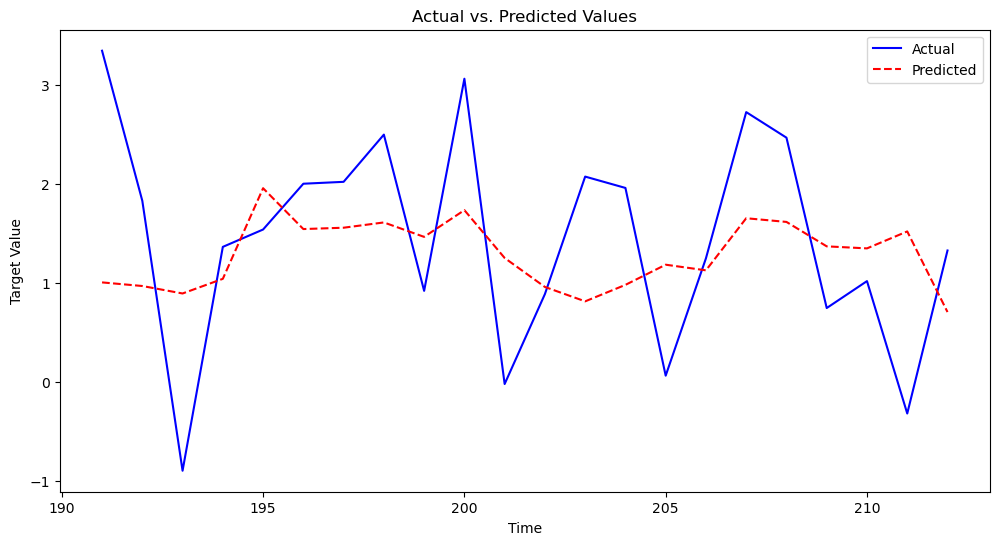

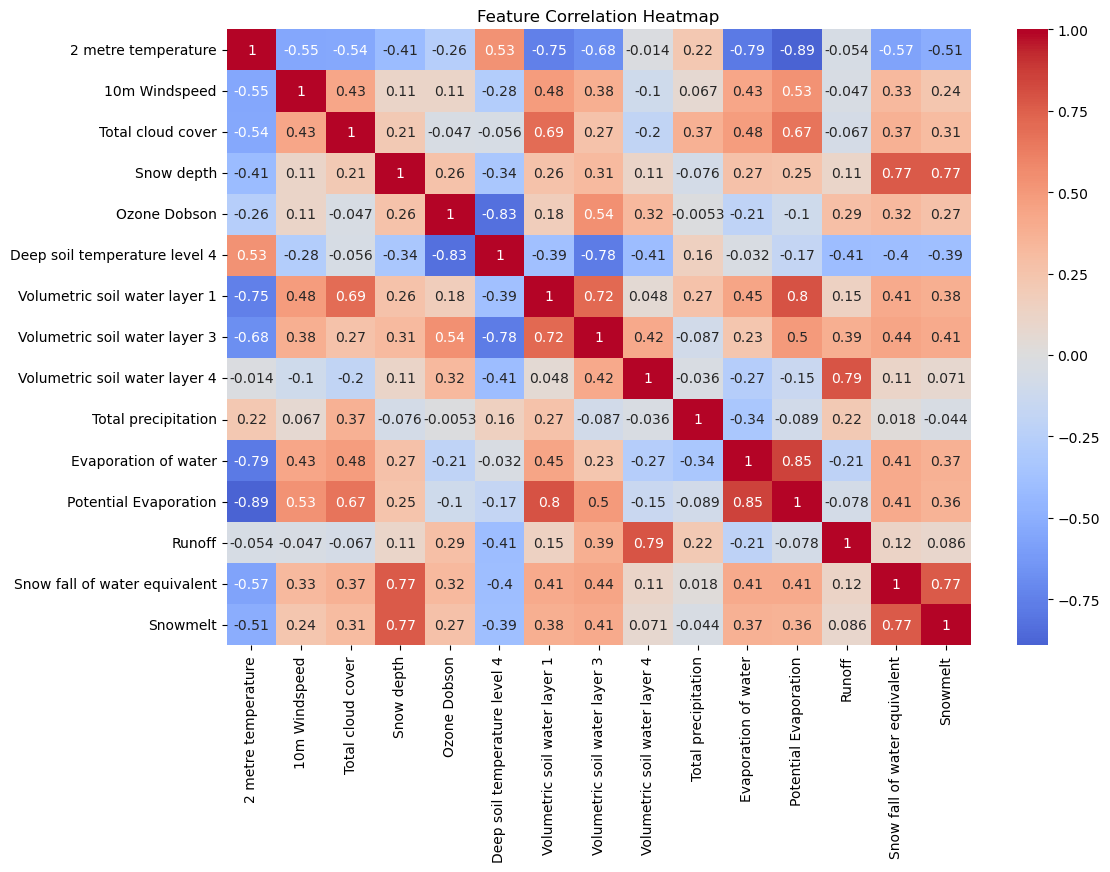

In [20]:
# Model allotment gardens
evi_aoi_allotments = choose_cat_and_merge(evi_aoi, categories, 'AX41008_AX_SportFreizeitUndErholungsflaeche__Kleingarten')
results_allotments = merge_with_era5(era_5_berlin,evi_aoi_allotments)
results_allotments = results_allotments.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_allotments = select_columns(results_allotments)
model_allotments = train_xgb(results_allotments)

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 1.1354
Root Mean Squared Error (RMSE): 1.0655
Mean Absolute Error (MAE): 0.8711
R² Score: 0.1259


<Figure size 1000x600 with 0 Axes>

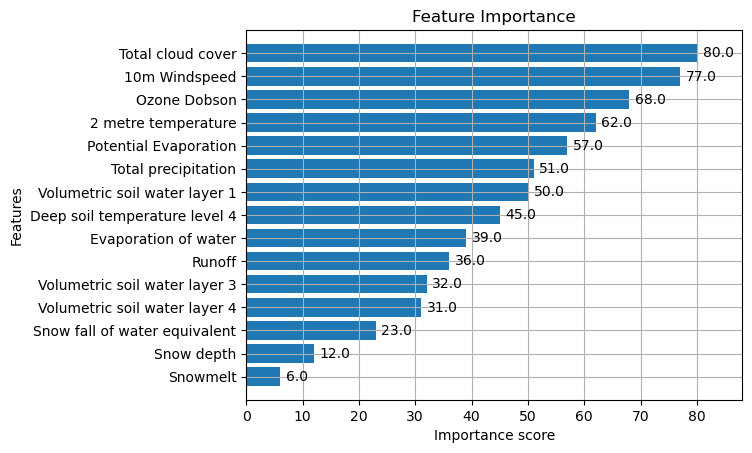

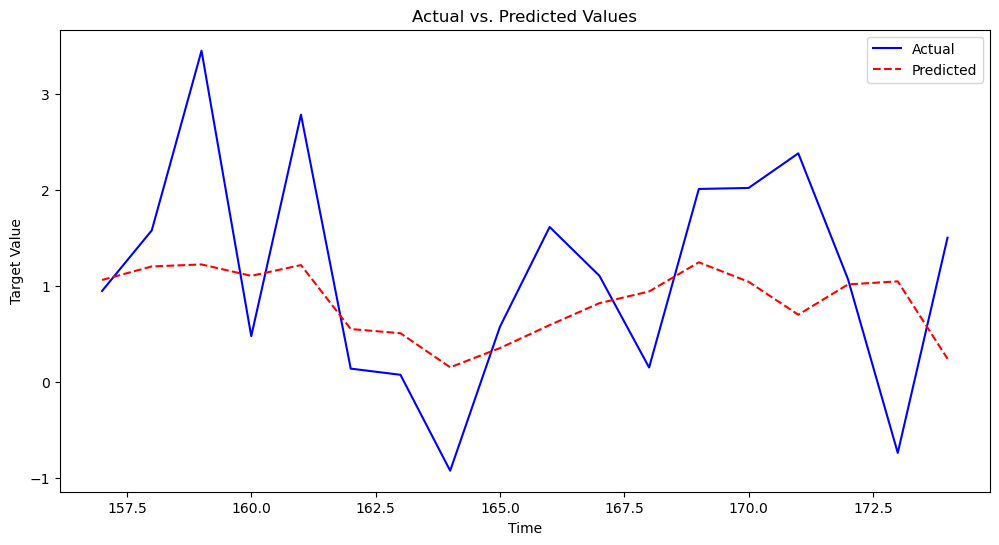

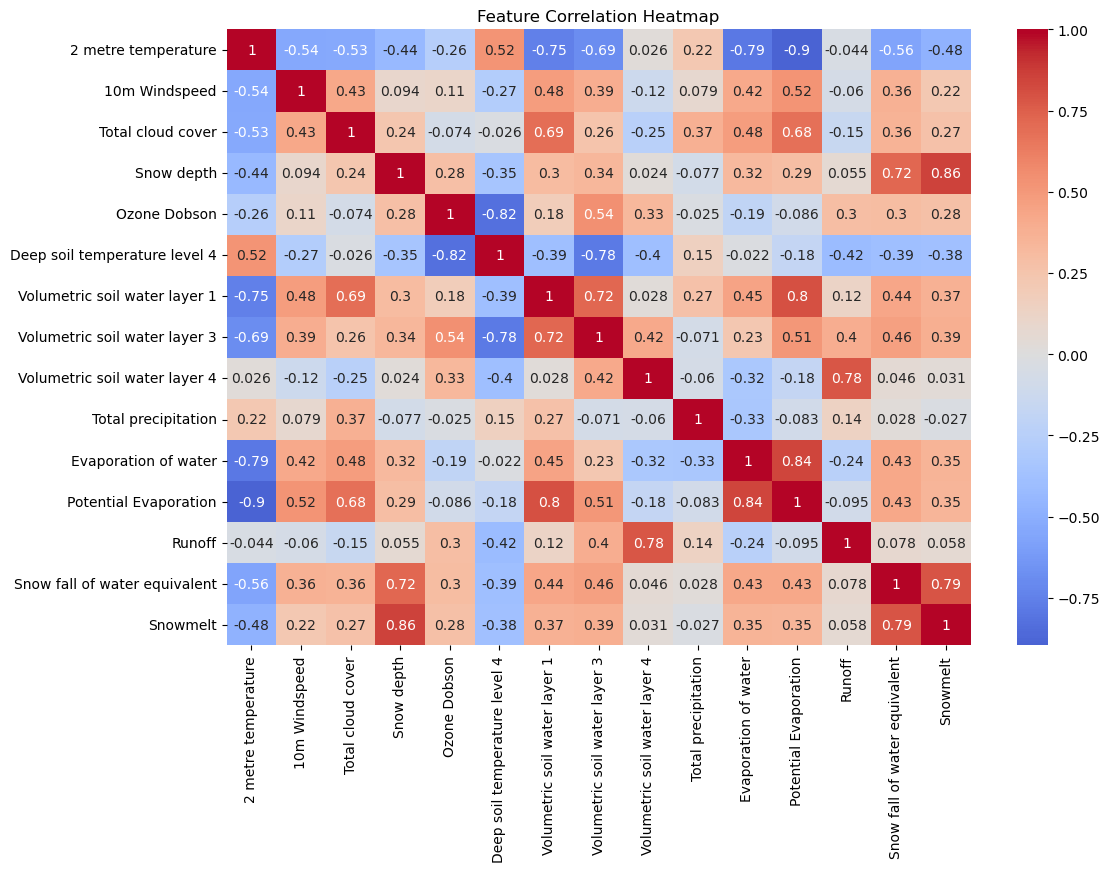

In [21]:
# Model semi-natural areas
evi_aoi_vegetationslos = choose_cat_and_merge(evi_aoi, categories, 'AX43007_AX_UnlandVegetationsloseFlaeche__Naturnahe Fläche')
results_vegetationslos = merge_with_era5(era_5_berlin,evi_aoi_vegetationslos)
results_vegetationslos = results_vegetationslos.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_vegetationslos = select_columns(results_vegetationslos)
model_vegetationslos = train_xgb(results_vegetationslos)

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Mean Squared Error (MSE): 1.1099
Root Mean Squared Error (RMSE): 1.0535
Mean Absolute Error (MAE): 0.9168
R² Score: 0.5881


<Figure size 1000x600 with 0 Axes>

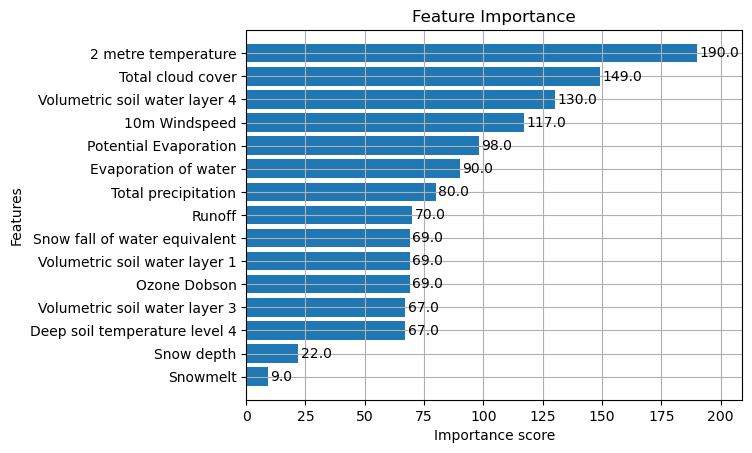

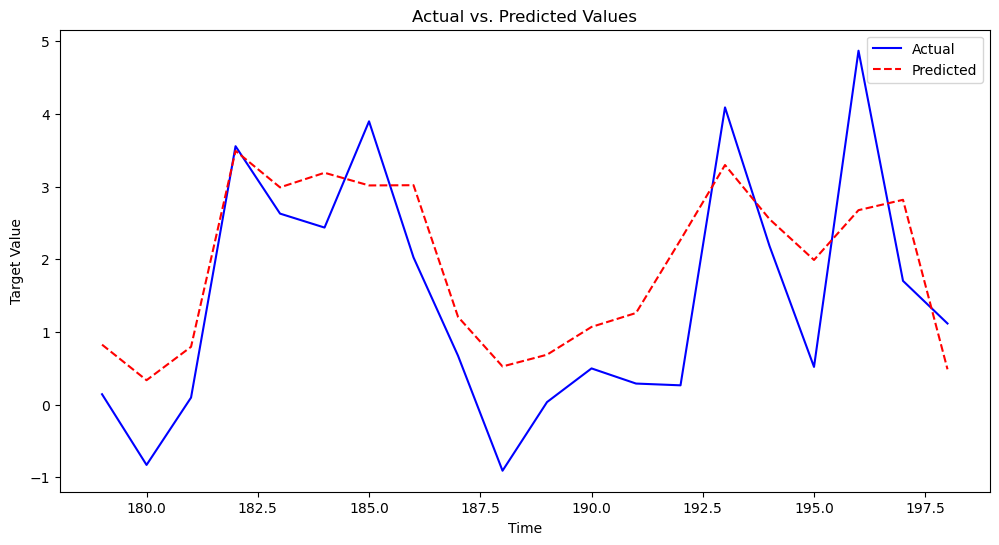

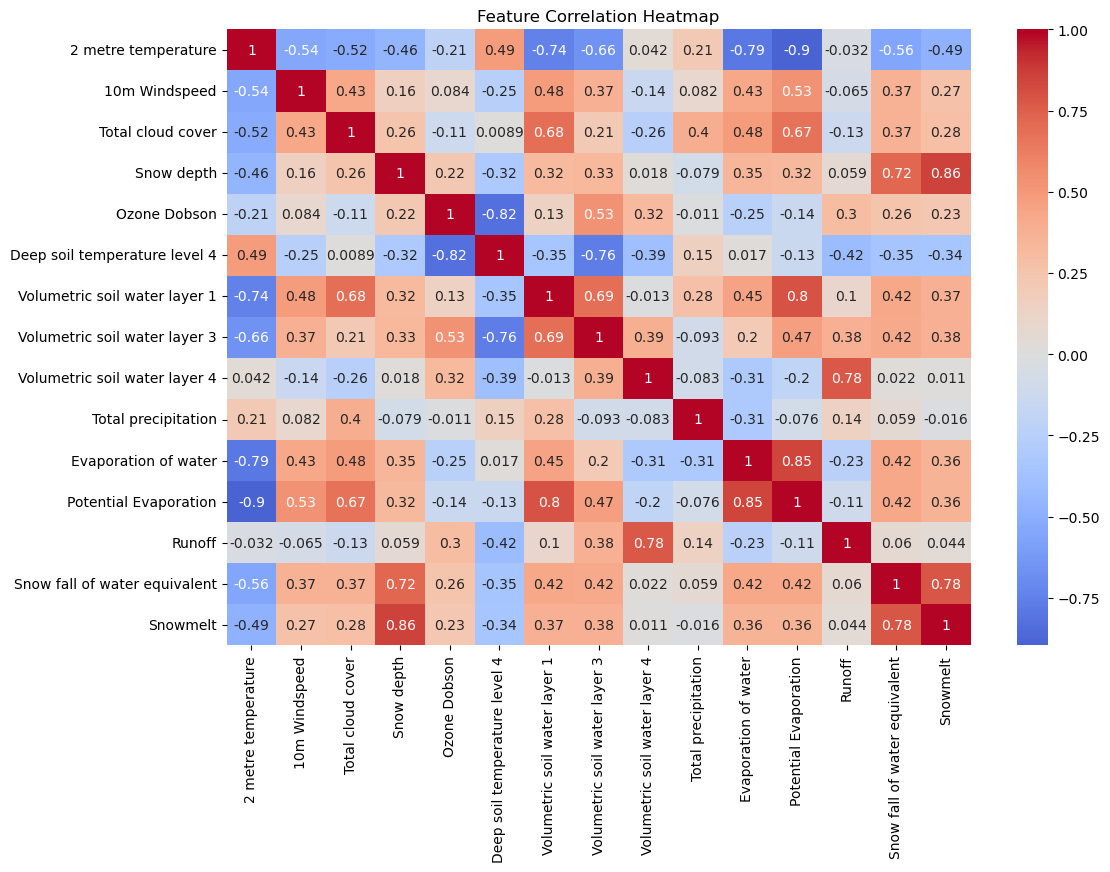

In [22]:
# Model Forest
evi_aoi_forest = choose_cat_and_merge(evi_aoi, categories, 'AX43002_AX_Wald_Laubholz_')
results_forest = merge_with_era5(era_5_berlin,evi_aoi_forest)
results_forest = results_forest.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_forest = select_columns(results_forest)
model_forest = train_xgb(results_forest)

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Mean Squared Error (MSE): 0.7032
Root Mean Squared Error (RMSE): 0.8386
Mean Absolute Error (MAE): 0.7149
R² Score: 0.3172


<Figure size 1000x600 with 0 Axes>

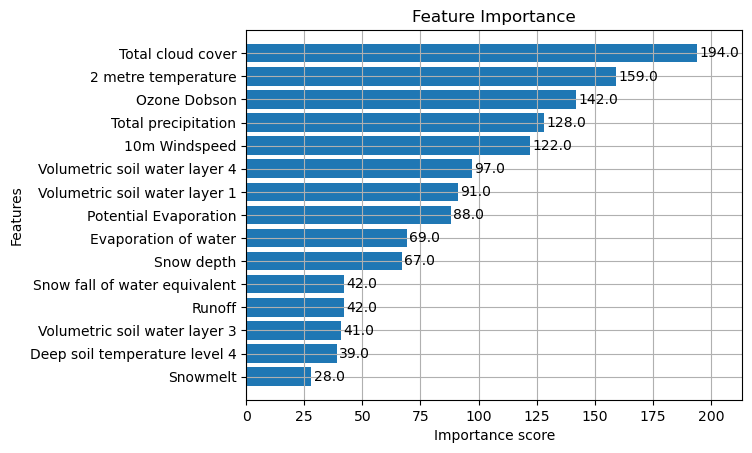

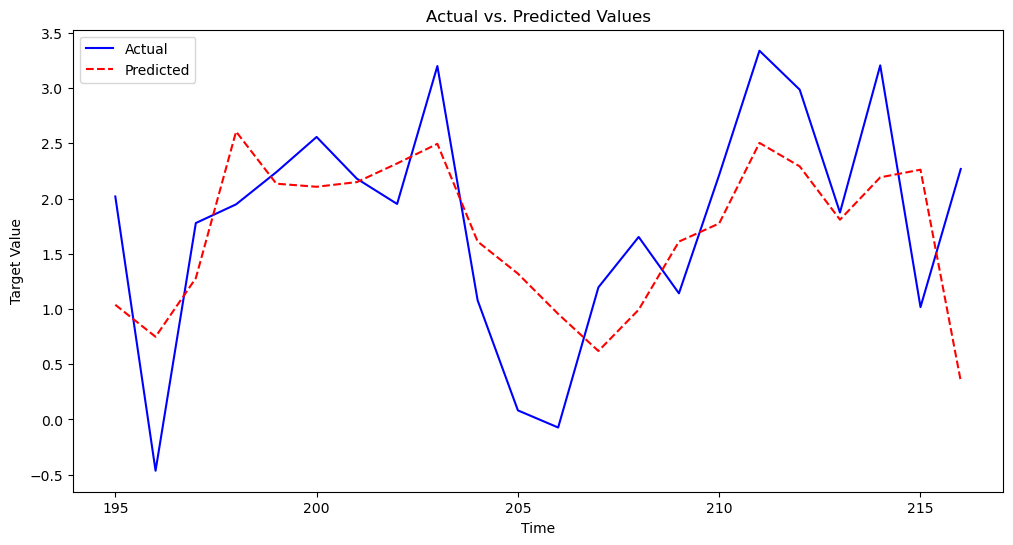

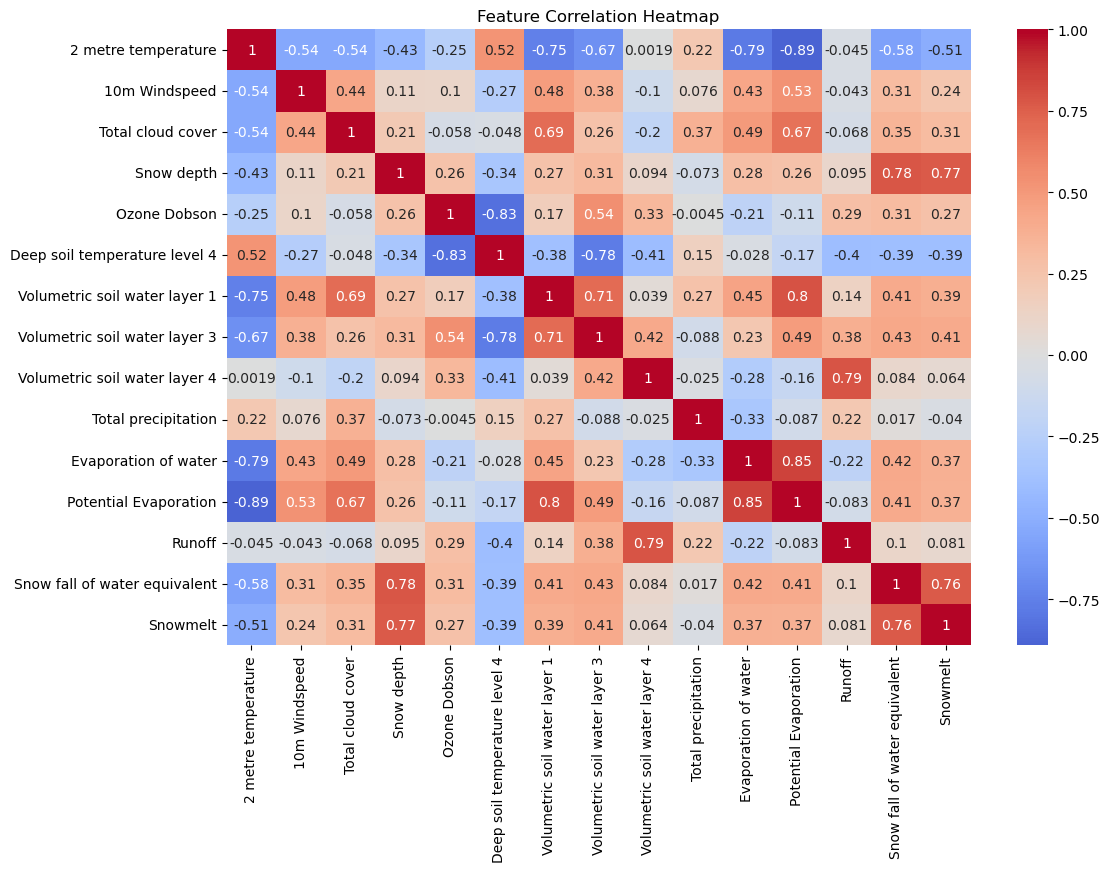

In [23]:
# Model Park
evi_aoi_sport_freizeit = choose_cat_and_merge(evi_aoi, categories, 'AX41008_AX_SportFreizeitUndErholungsflaeche__Park')
results_sport_freizeit = merge_with_era5(era_5_berlin,evi_aoi_sport_freizeit)

results_sport_freizeit = results_sport_freizeit.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_sport_freizeit = select_columns(results_sport_freizeit)
model_sport_freizeit = train_xgb(results_sport_freizeit)

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 0.8985
Root Mean Squared Error (RMSE): 0.9479
Mean Absolute Error (MAE): 0.7881
R² Score: 0.2267


<Figure size 1000x600 with 0 Axes>

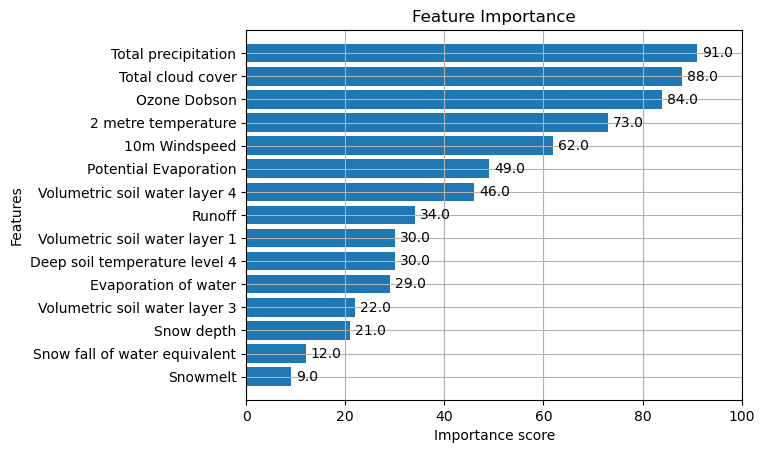

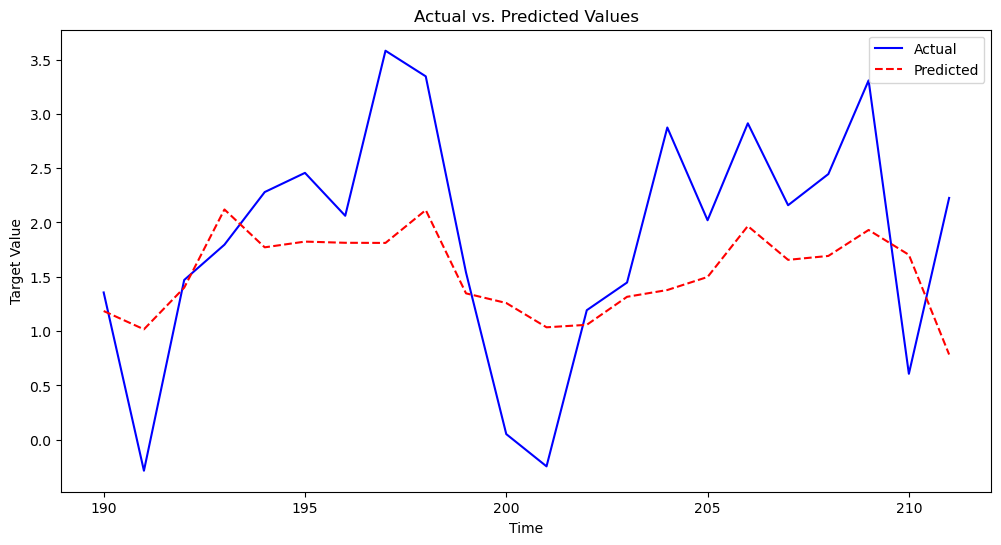

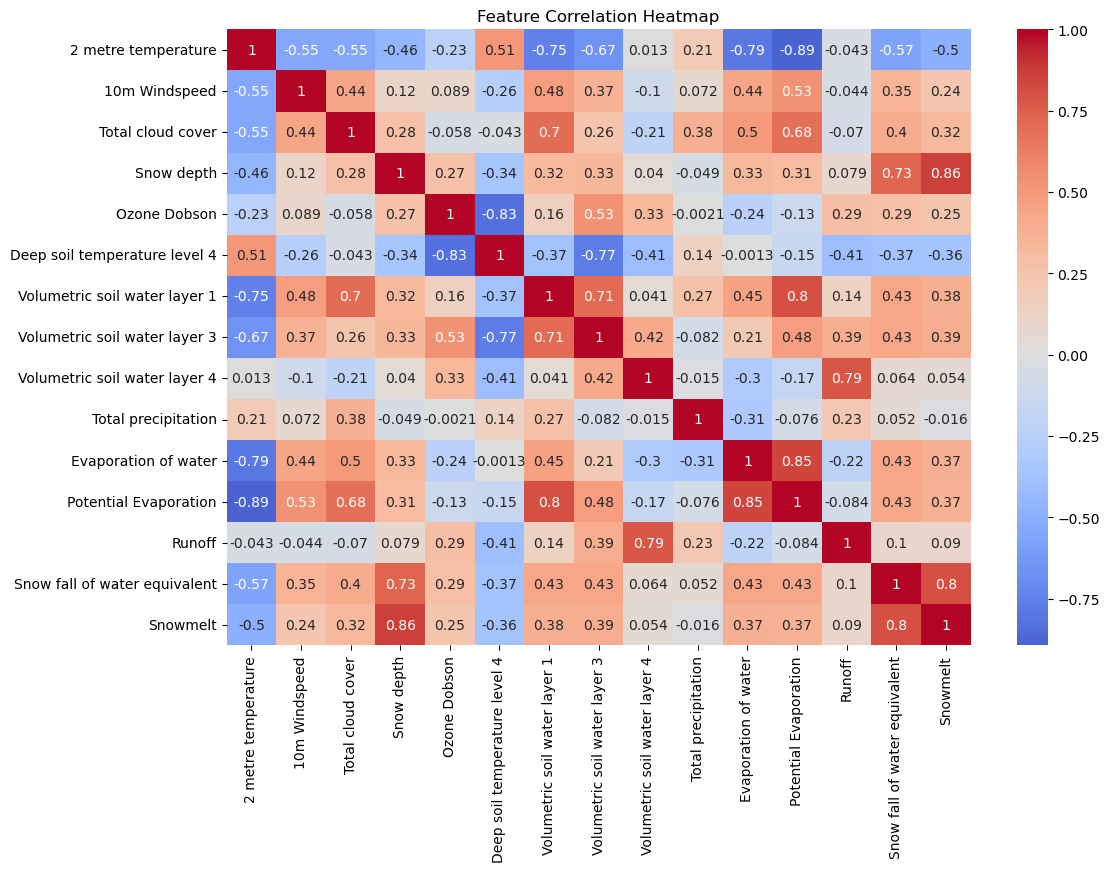

In [24]:
# Model Woods
evi_aoi_gehoelz = choose_cat_and_merge(evi_aoi, categories, 'AX54001_AX_Vegetationsmerkmal__Gehölz__')
results_gehoelz = merge_with_era5(era_5_berlin,evi_aoi_gehoelz)
results_gehoelz = results_gehoelz.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_gehoelz = select_columns(results_gehoelz)
model_holz = train_xgb(results_gehoelz)

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 0.6450
Root Mean Squared Error (RMSE): 0.8031
Mean Absolute Error (MAE): 0.6789
R² Score: 0.1396


<Figure size 1000x600 with 0 Axes>

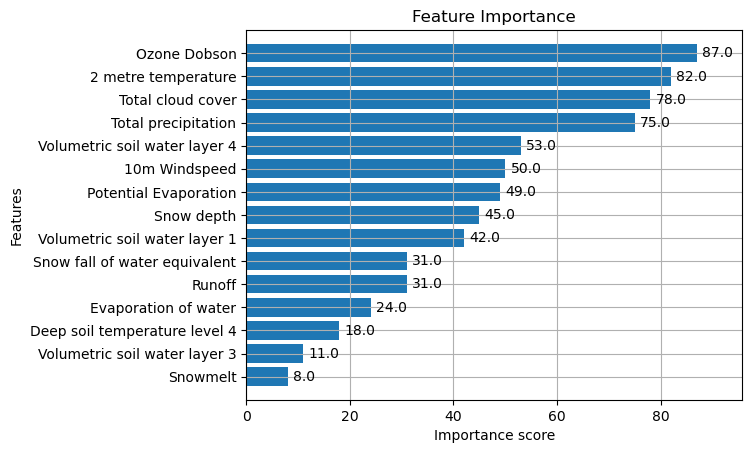

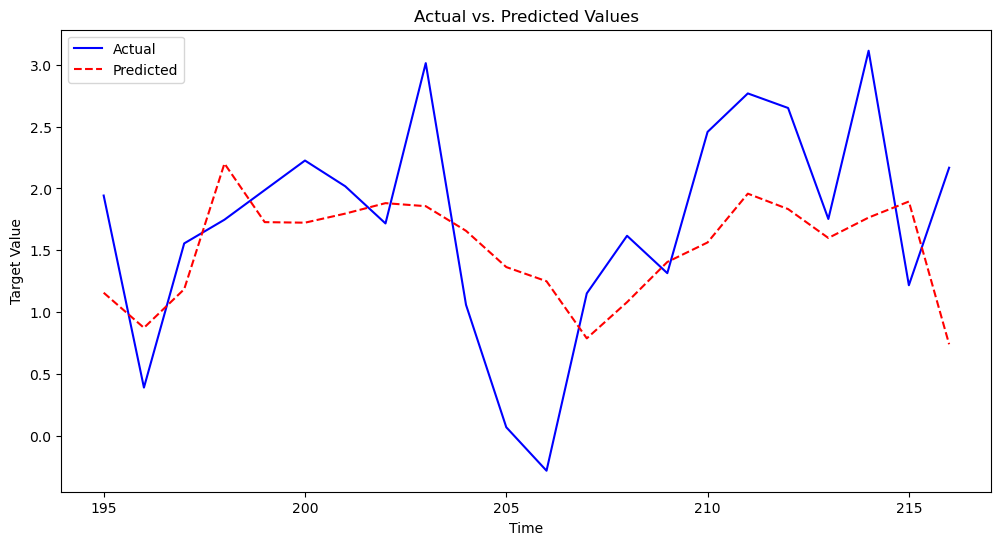

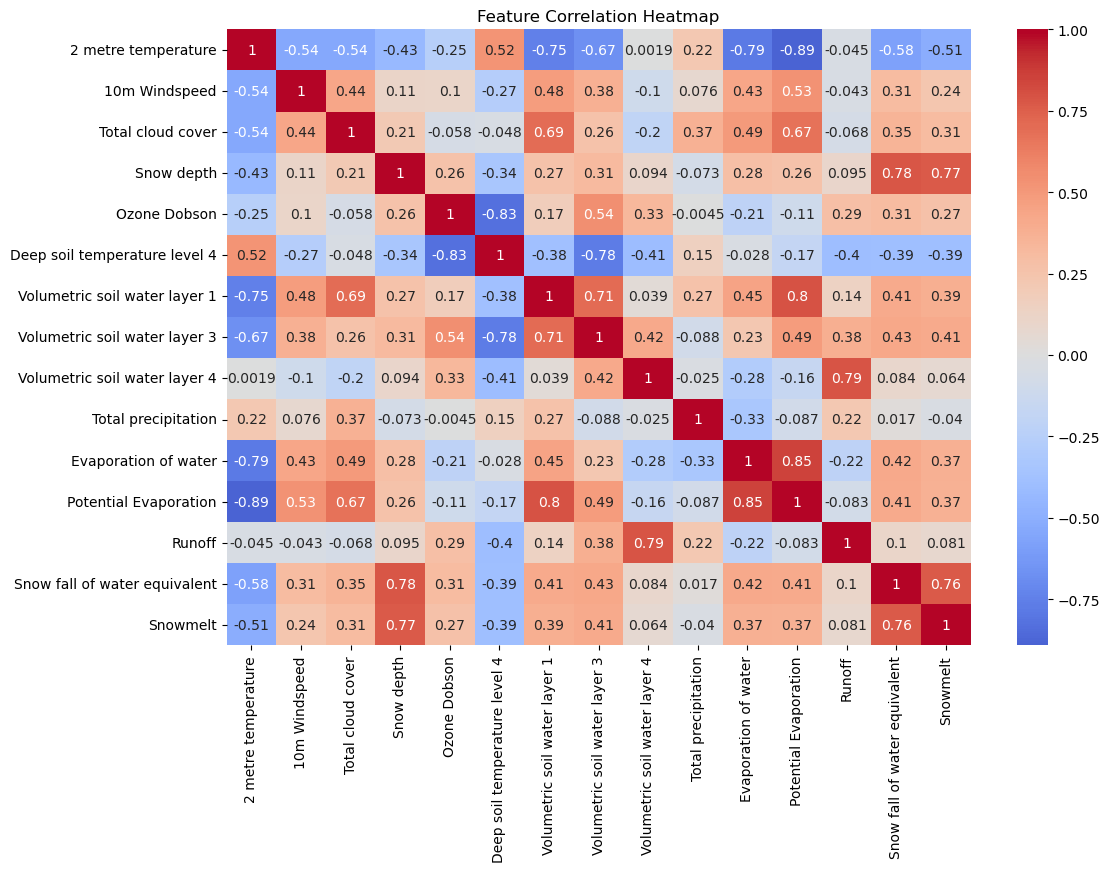

In [25]:
# Model Parks
evi_aoi_gruenanlage = choose_cat_and_merge(evi_aoi, categories, 'Grünanlage')
results_gruenanlage = merge_with_era5(era_5_berlin,evi_aoi_gruenanlage)
results_gruenanlage = results_gruenanlage.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_gruenanlage = select_columns(results_gruenanlage)
model_gruenanlage = train_xgb(results_gruenanlage)

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 0.8244
Root Mean Squared Error (RMSE): 0.9079
Mean Absolute Error (MAE): 0.7464
R² Score: 0.1493


<Figure size 1000x600 with 0 Axes>

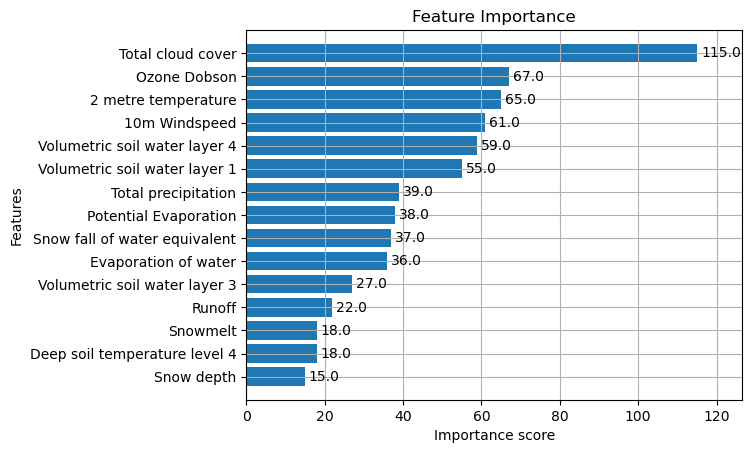

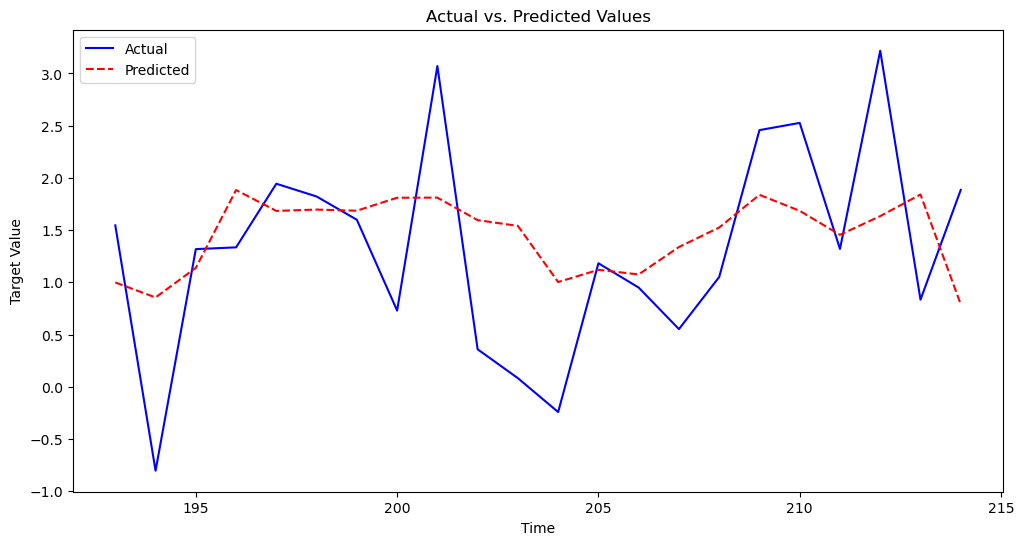

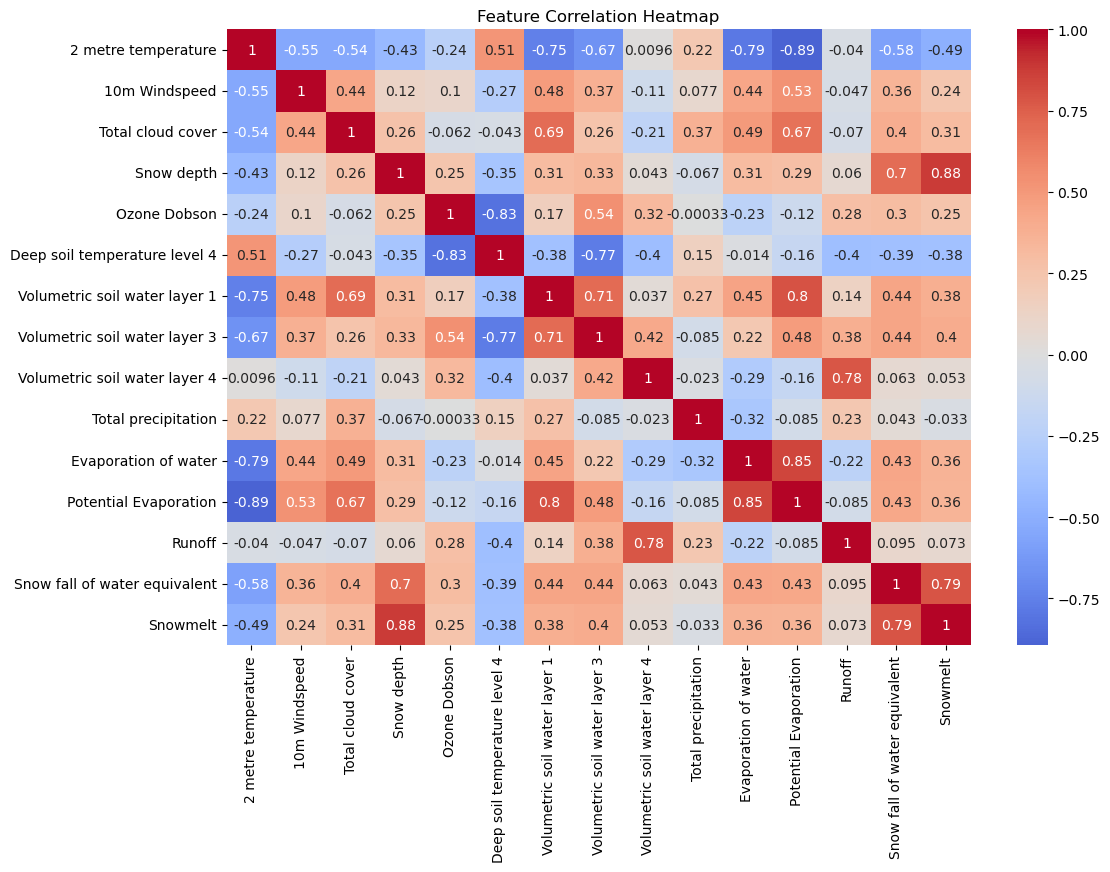

In [26]:
# Model Playgrounds
evi_aoi_spielplatz = choose_cat_and_merge(evi_aoi, categories, 'Spielplatz')
results_spielplatz = merge_with_era5(era_5_berlin,evi_aoi_spielplatz)
results_spielplatz = results_spielplatz.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_spielplatz = select_columns(results_spielplatz)
model__spielplatz = train_xgb(results_spielplatz)

Removed columns due to high collinearity: ['Water [kg/m^2]', 'Surf.temp lev 1', 'Deep soil temp lev2', 'Deep soil tmp lev3', 'Volumetric soil water layer 2', 'Instantaneous 10 metre wind gust']
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 1.4444
Root Mean Squared Error (RMSE): 1.2018
Mean Absolute Error (MAE): 1.0373
R² Score: 0.3010


<Figure size 1000x600 with 0 Axes>

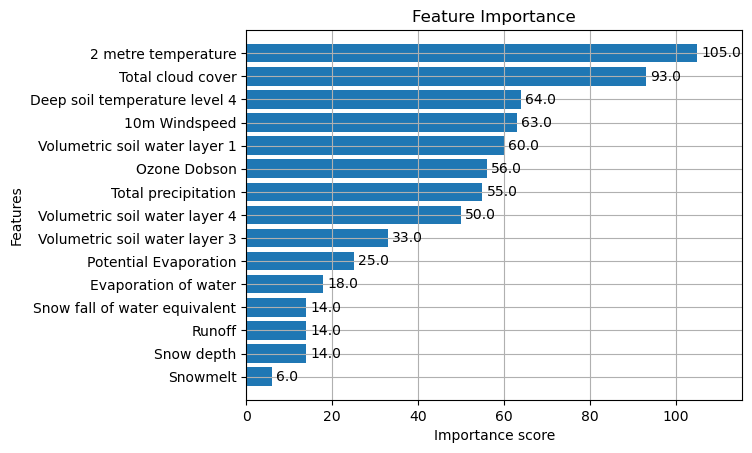

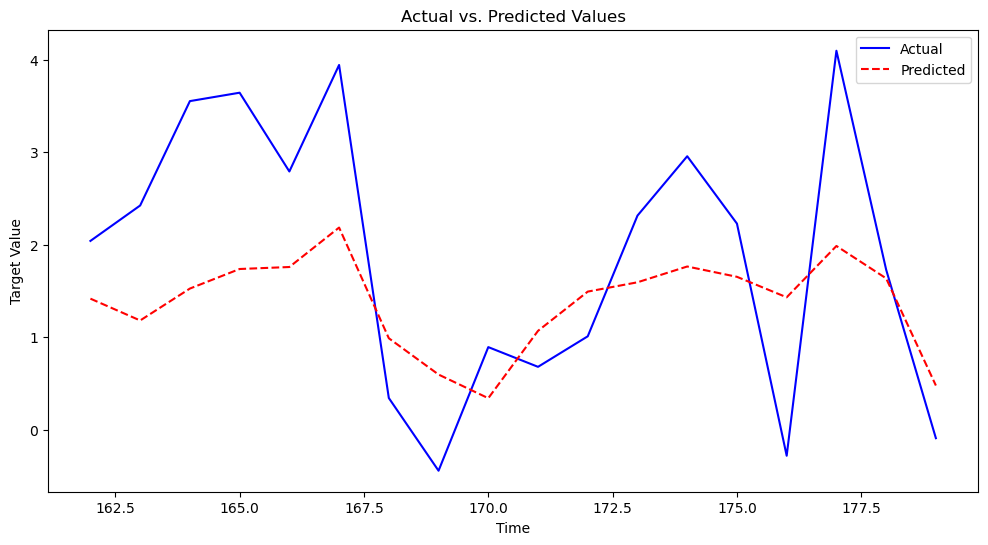

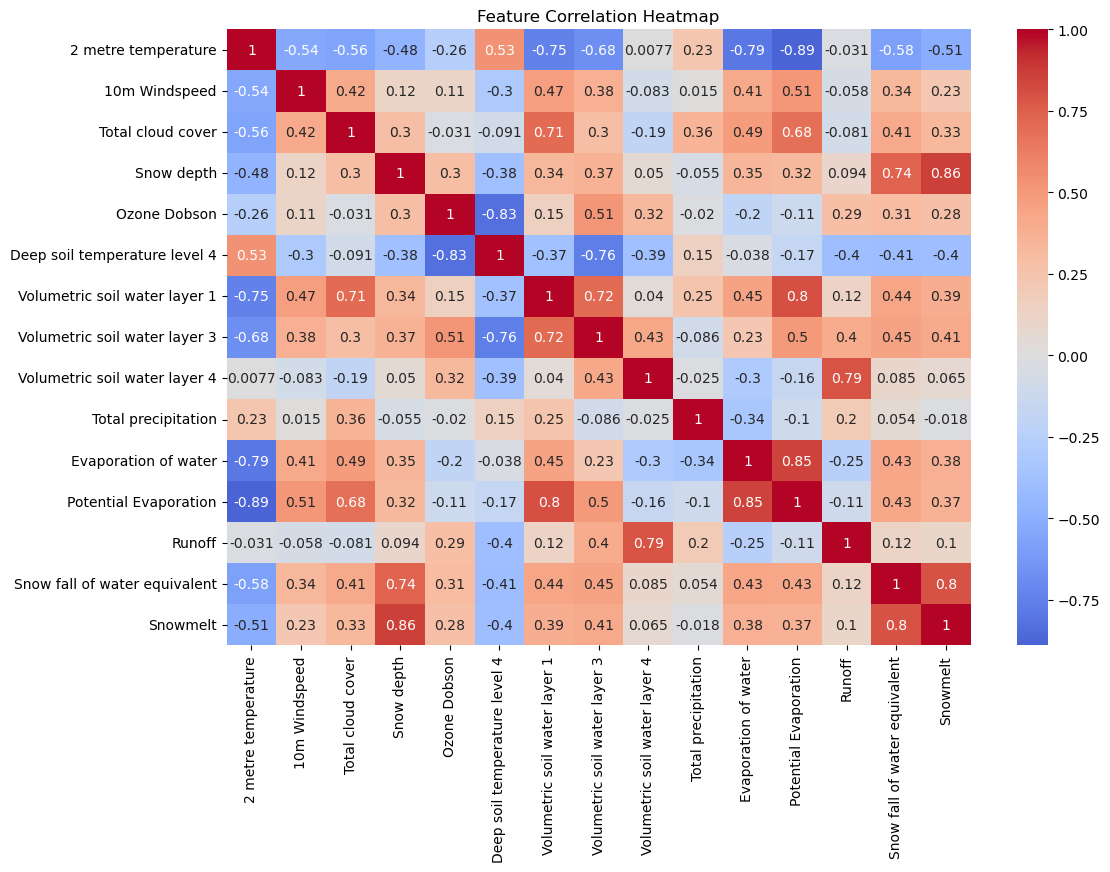

In [27]:
# Model Game Reserve
evi_aoi_wildgehege = choose_cat_and_merge(evi_aoi, categories, 'AX51006_AX_BauwerkOderAnlageFuerSportFreizeitUndErholung_Wildgehege___')
results_wildgehege = merge_with_era5(era_5_berlin,evi_aoi_wildgehege)
results_wildgehege = results_wildgehege.drop(columns=['cell','x','y','date_key','cell_x', 'x_x', 'y_x', 'time', 'cell_y', 'x_y', 'y_y', 'layer_x', 'layer_y'], errors='ignore')
results_wildgehege = select_columns(results_wildgehege)
model_wildgehege = train_xgb(results_wildgehege)